In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [4]:
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000019
2019-01-02,2019-01-03,0.000019
2019-01-03,2019-01-04,0.000028
2019-01-04,2019-01-05,0.000037
2019-01-05,2019-01-06,-0.000018


In [8]:
bibile_data = data[["HCHO reading"]]
bibile_data.head() 

,HCHO reading
Current Date,
2019-01-01,0.000019
2019-01-02,0.000019
2019-01-03,0.000028
2019-01-04,0.000037
2019-01-05,-0.000018


In [9]:
bibile_data.shape 

(1826, 1)

In [10]:
X = bibile_data.values 

#### This looks like that Bibile fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

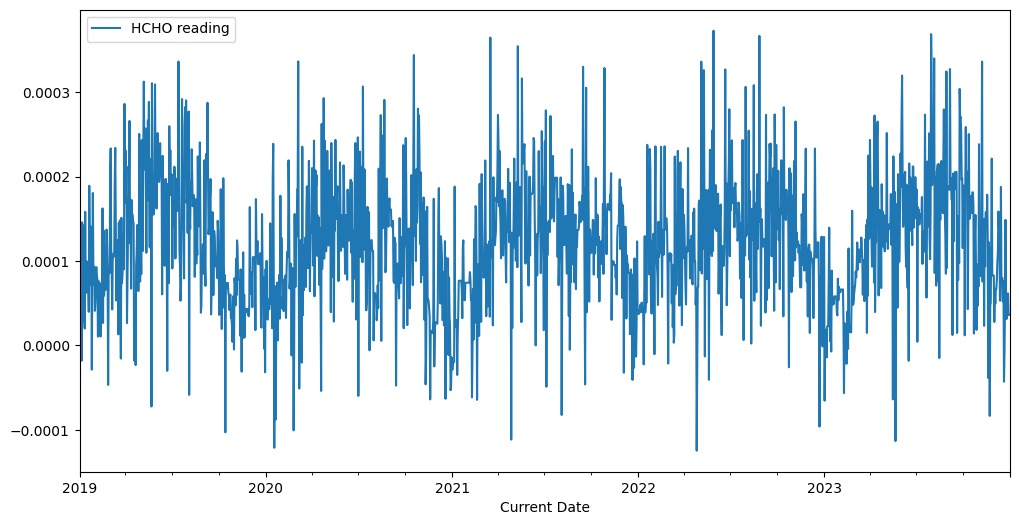

In [12]:
bibile_data.plot(figsize=(12, 6)) 

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
test_bibile = adfuller(bibile_data["HCHO reading"], autolag="AIC")

In [16]:
print("ADF value : ", test_bibile[0])
print("P value: ", test_bibile[1])
print("Num of Lags :", test_bibile[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_bibile[3])
for key, val in test_bibile[4].items():
    print("\t", key, ": ", val)

ADF value :  -6.190170498936145
P value:  6.150214800037883e-08
Num of Lags : 11
Num of Observations used for ADF Regression and Critical Calculation : 1814
	 1% :  -3.4339600207952796
	 5% :  -2.863134623063046
	 10% :  -2.5676189242070433


#### Auto correlation and correlation plot for Bbile Monaragala

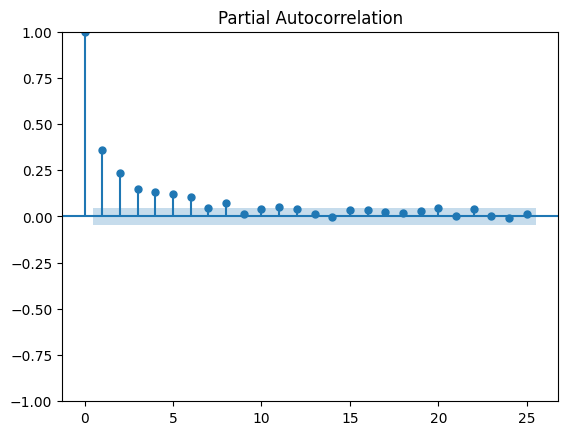

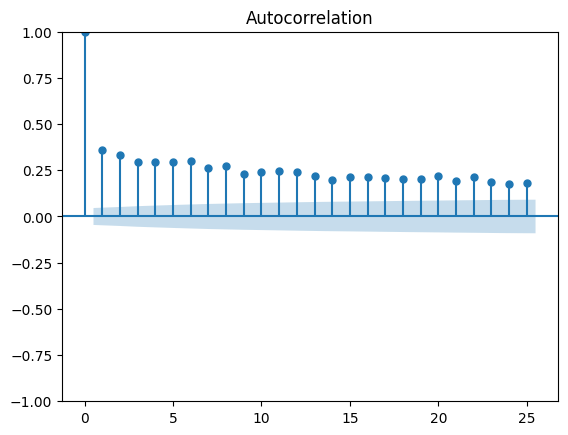

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(bibile_data["HCHO reading"], lags=25)
acf = plot_acf(bibile_data["HCHO reading"], lags=25)  

#### This auto correlation and partial correlation plots show there is a seasonality in the data

#### Bibile Monaragala LSTM

In [28]:
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [29]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000019
1   2019-01-02      0.000019
2   2019-01-03      0.000028
3   2019-01-04      0.000037
4   2019-01-05     -0.000018


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, -1])  # Assuming target is the last column
    return np.array(X), np.array(y)

sequence_length = 7# Adjust sequence length as necessary

# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  
    Bidirectional(LSTM(units=50)),  
    Dropout(0.2),  
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])


# Train the model
history = model.fit(X_train, y_train, epochs=120, batch_size=32, validation_split=0.2)

Epoch 1/120
37/37 [==============================] - 78s 904ms/step - loss: 1.2029 - mean_squared_error: 1.2029 - val_loss: 0.9403 - val_mean_squared_error: 0.9403
Epoch 2/120
37/37 [==============================] - 14s 392ms/step - loss: 0.8927 - mean_squared_error: 0.8927 - val_loss: 0.9056 - val_mean_squared_error: 0.9056
Epoch 3/120
37/37 [==============================] - 18s 480ms/step - loss: 0.8767 - mean_squared_error: 0.8767 - val_loss: 0.9181 - val_mean_squared_error: 0.9181
Epoch 4/120
37/37 [==============================] - 16s 424ms/step - loss: 0.8441 - mean_squared_error: 0.8441 - val_loss: 1.2985 - val_mean_squared_error: 1.2985
Epoch 5/120
37/37 [==============================] - 16s 439ms/step - loss: 0.8211 - mean_squared_error: 0.8211 - val_loss: 0.9205 - val_mean_squared_error: 0.9205
Epoch 6/120
37/37 [==============================] - 23s 627ms/step - loss: 0.8102 - mean_squared_error: 0.8102 - val_loss: 1.1089 - val_mean_squared_error: 1.1089
Epoch 7/120
37/3

Epoch 51/120
37/37 [==============================] - 18s 488ms/step - loss: 0.4693 - mean_squared_error: 0.4693 - val_loss: 0.9790 - val_mean_squared_error: 0.9790
Epoch 52/120
37/37 [==============================] - 18s 473ms/step - loss: 0.3872 - mean_squared_error: 0.3872 - val_loss: 1.1812 - val_mean_squared_error: 1.1812
Epoch 53/120
37/37 [==============================] - 17s 465ms/step - loss: 0.3730 - mean_squared_error: 0.3730 - val_loss: 1.0715 - val_mean_squared_error: 1.0715
Epoch 54/120
37/37 [==============================] - 14s 387ms/step - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 1.0311 - val_mean_squared_error: 1.0311
Epoch 55/120
37/37 [==============================] - 15s 418ms/step - loss: 0.3176 - mean_squared_error: 0.3176 - val_loss: 1.2115 - val_mean_squared_error: 1.2115
Epoch 56/120
37/37 [==============================] - 16s 431ms/step - loss: 0.3010 - mean_squared_error: 0.3010 - val_loss: 1.0826 - val_mean_squared_error: 1.0826
Epoch 57/1

Epoch 101/120
37/37 [==============================] - 16s 435ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 1.0858 - val_mean_squared_error: 1.0858
Epoch 102/120
37/37 [==============================] - 17s 463ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 1.0743 - val_mean_squared_error: 1.0743
Epoch 103/120
37/37 [==============================] - 17s 471ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 1.0045 - val_mean_squared_error: 1.0045
Epoch 104/120
37/37 [==============================] - 19s 512ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 1.1649 - val_mean_squared_error: 1.1649
Epoch 105/120
37/37 [==============================] - 17s 473ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 1.1447 - val_mean_squared_error: 1.1447
Epoch 106/120
37/37 [==============================] - 16s 442ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 1.1140 - val_mean_squared_error: 1.1140
Epoc

12/12 [==============================] - 11s 120ms/step


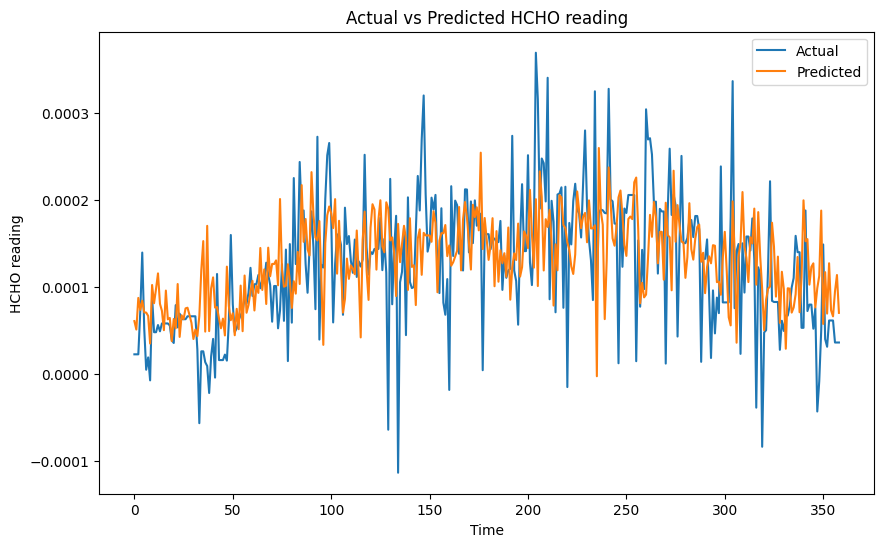

In [31]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 6s 128ms/step


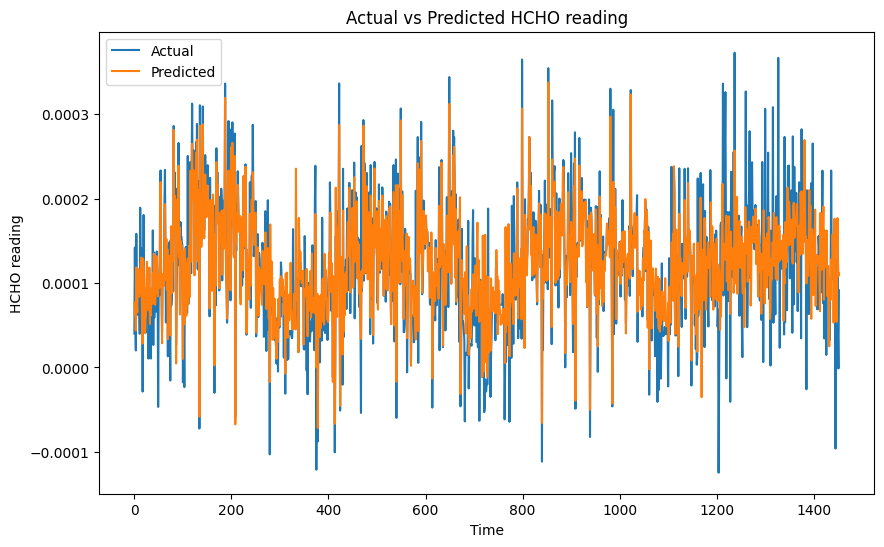

In [32]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 6s 118ms/step


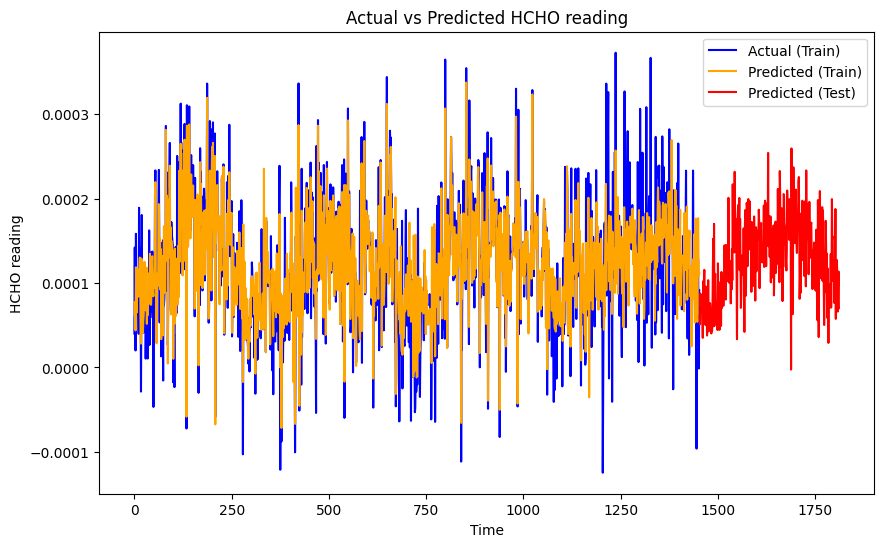

In [33]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [34]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6388051385219051
Mean Absolute Error (MAE): 2.8173545403085707e-05
Mean Squared Error (MSE): 1.8750407967141595e-09
Root Mean Squared Error (RMSE): 4.330174126653753e-05
Median Absolute Error: 1.6345823735944656e-05
Explained Variance Score: 0.6412629438611841


21:29:04 - cmdstanpy - INFO - Chain [1] start processing
21:29:05 - cmdstanpy - INFO - Chain [1] done processing


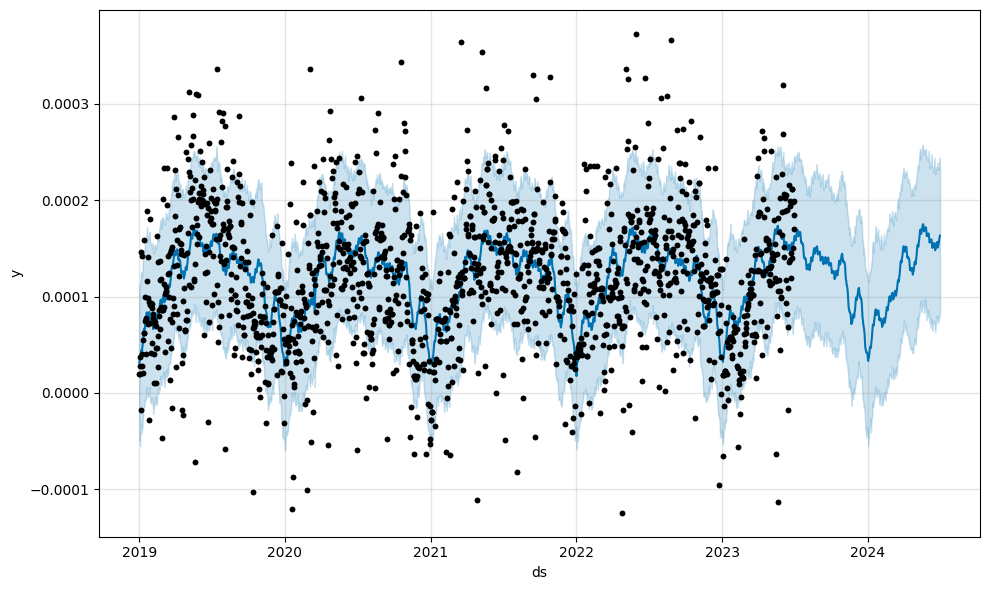

In [109]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

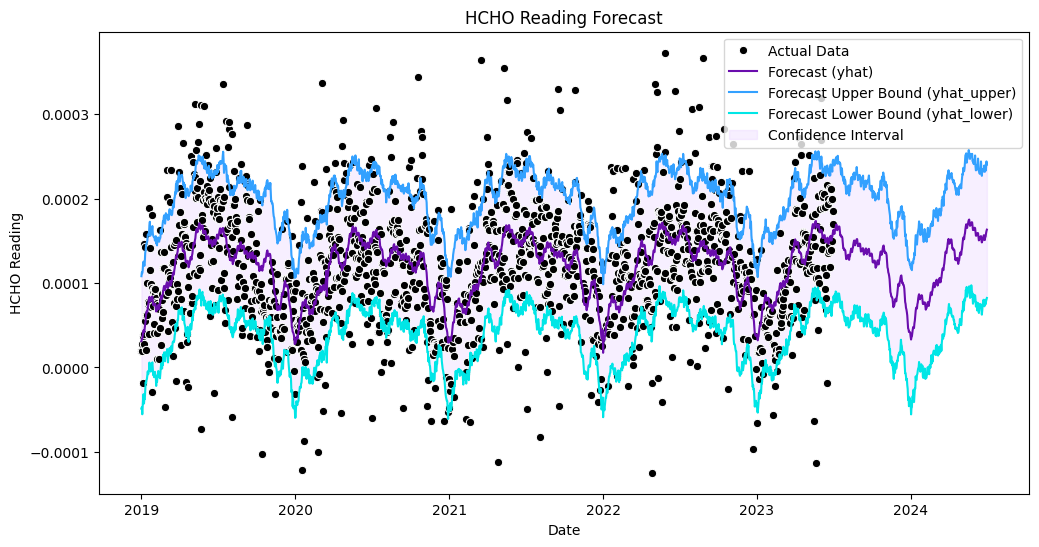

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

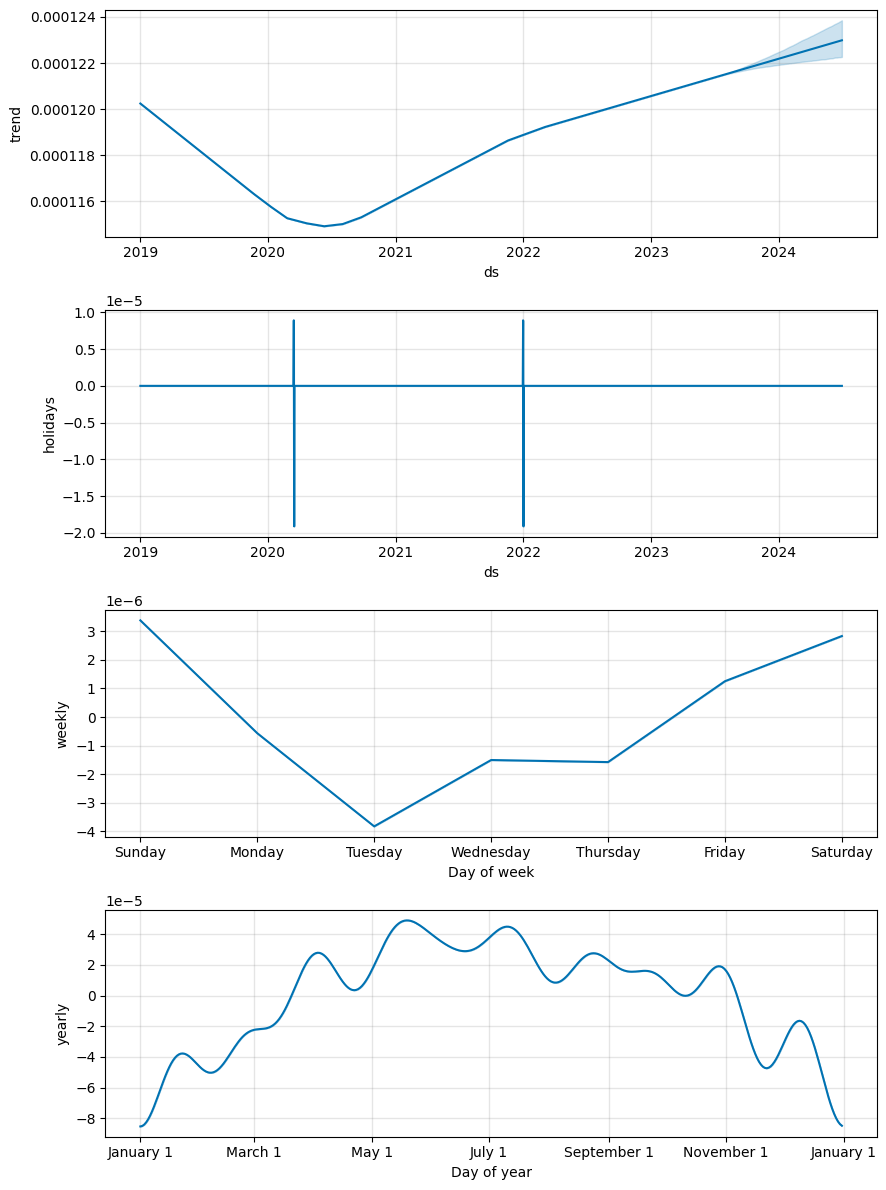

In [111]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [112]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.13282739862940995
Mean Absolute Error (MAE): 5.667339857151609e-05
Mean Squared Error (MSE): 5.321903636499948e-09
Root Mean Squared Error (RMSE): 7.295137857847478e-05
Median Absolute Error: 4.799754309937166e-05
Explained Variance Score: 0.1775401590932143
